# COGS 108 - Final Project 

# Overview

Our project is looking at the correlation between movie genre popularity and GDP. To analyze this, we found datasets relating to our hypothesis, and manipulated them to answer our question. We had to clean the datasets to get data we can work with and visualize. We created graphs to see relationships that relate to our hypothesis, and analyzed them.

# Names

- Jason Lee
- Laurent Lee
- Qingyang Xu
- Tianze Zhang
- Yue Jiao


# Group Members IDs


- XXXXXXXXX
- XXXXXXXXX
- XXXXXXXXX
- XXXXXXXXX
- XXXXXXXXX





# Research Question

How does GDP per capita correlate to the popularity of certain movie genres in USA? 


## Background and Prior Work

Movies are not merely just entertainment. They can let us experience what we could not do in reality and rich emotions. Reports have shown that films could evoke emotions within us. It is evident that individuals have different movie genre preferences, and preferences could be affected by a lot of factors. For example, GDP per capita is a measure of economic strength, which is related to people’s personal income. In this project, we aim to investigate the correlation between change in GDP per capita and people’s movie genre preferences. We want unbiased data and visualizations to demonstrate this correlation. 

References (include links):
- 1) https://www.scpr.org/news/2014/12/04/48457/what-watching-movies-can-tell-us-about-how-our-bra/ 
- 2) https://www.thebalance.com/gdp-per-capita-formula-u-s-compared-to-highest-and-lowest-3305848

# Hypothesis



Since GDP per capita is directly related to people’s incomes and lower income could cause people to be depressed, we suspect that when the GDP per capita of a certain time period is lower, people prefer to watch more relaxing movies such as comedies, dramas, and romance, while when the GDP per capita of a certain time period is higher, people prefer to watch more thrilling movies such as horror, action, and adventure. 


# Dataset(s)

### - Dataset Name: movies_metadata.csv
- Link to the dataset: https://www.kaggle.com/rounakbanik/the-movies-dataset/home#movies_metadata.csv
- Number of observations: 45,376
- This dataset was a csv file containing many different movies from the past several decades. Each movie had their genre, a popularity score, and the year they came out.


### - Dataset Name: gdp.csv
- Link to the dataset: https://data.worldbank.org/indicator/NY.GDP.PCAP.KD.ZG?locations=US
- Number of observations: 264
- This data set was a csv file that contained the GDP per capita over the years.

We will combine the data from these sources into a dataframe. We will then compare the data from these datasets to see how thrilling and relaxing genres perform vs GDP.


# Setup

Imports used in project:

In [1]:
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning

In order to clean our data from the dataset, we represent the data in a pandas dataframe for both our datasets: gdp.csv and movies_metadata.csv. We then drop irrelevant data from the dataframe and rename the columns.

In [2]:
# add change in gdp data
data = pd.read_csv('gdp.csv')
data.set_index('Country Name', inplace = True)
data = data.loc['United States', :]
data = data.dropna()
data = data.drop('Country Code')
data = data.drop('Indicator Code')
data = data.drop('Indicator Name')

#rename the dataframe
gdp = pd.DataFrame(data)
gdp = gdp.reset_index()
gdp.columns = ['date','GDP']
# change the gdp to numeric 
gdp["date"] = pd.to_numeric(gdp["date"])

In [3]:
#read in data from .csv
df_movies = pd.read_csv('movies_metadata.csv')

#drop irrelevant columns
df_movies.drop(columns=['homepage', 'id', 'imdb_id', 'original_language', 'overview',
                        'spoken_languages', 'status', 'tagline', 'poster_path',
                        'production_countries', 'video', 'production_companies',
                        'adult', 'belongs_to_collection', 'original_title', 'budget', 
                        'revenue', 'runtime', 'vote_average', 'vote_count'],
                         inplace=True)

#rename and move around columns
df_movies.columns = ['genres', 'popularity', 'date', 'title']
df_movies = df_movies[['title', 'date', 'genres', 'popularity']]
#df_movies

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#drop rows that do not have data for title or release date
df_movies.dropna(subset=['date', 'title'], inplace=True)

The date column of the dataframe had dates in the format “year-month-date”, but we only needed the year for each movie. We created a method called standardize_date_movie to only get the year from each date and store it back into the dataframe. We also sort the dataframe by the date and drop movies that do not have data for the genre column.

In [5]:
# Convert all inputs to strings and normalize them
def standardize_date_movie(long):
    string = str(long)
    string = string.strip()
    string = string[0:4]
    date = int(string)
    return string

In [6]:
# Apply standardization and drop any movies out of the date boundary
df_movies["date"] = df_movies["date"].apply(standardize_date_movie)
df_movies.dropna(inplace=True)

#change it to numeric
df_movies["date"] = pd.to_numeric(df_movies["date"])

# change the popularity to numeric 
df_movies["popularity"] = pd.to_numeric(df_movies["popularity"])

#sort the columns
df_movies.sort_values(by=['date'], ascending=True, inplace = True)

# take all movies from 1971 to 2017 and get rid of other ones
df_movies = df_movies.loc[(df_movies["date"] > 1960) & (df_movies["date"] < 2017)]

#drop empty genres
df_movies = df_movies[~df_movies['genres'].isin(['[]'])]

df_movies.head()


,title,date,genres,popularity
19585,Creature from the Haunted Sea,1961,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",0.297889
17874,On the Double,1961,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",1.358690
3802,Voyage to the Bottom of the Sea,1961,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",3.013584
37369,"Nikki, Wild Dog of the North",1961,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",0.037374
25543,Fire in Castilla (Tactilvision from the Moor o...,1961,"[{'id': 99, 'name': 'Documentary'}]",0.337238


The next step is to separate the movies by genre and store the movies into genre dataframes. The genres we classified at relaxing are Drama, Romance, and Comedy, and the genres we classified as thrilling are action, adventure, and thriller. We made a method called genre_df to separate the movies into their own genre dataframe.

In [7]:
#funtion to generate new dataframe based on genre
def genre_df(string):
    df = pd.DataFrame(columns=['title', 'date','genres','popularity'])
    for index, row in df_movies.iterrows():
        if string in row['genres']:
            df.loc[len(df.index)] = df_movies.loc[index]
    
    #clean up the new dataframe
    df.drop('genres', axis=1, inplace=True)
    df = df.reset_index()
    df = df.drop(['title'], axis = 1)
    df = df.groupby(['date']).mean()
    df = df.drop('index', axis = 1)
    return df

In [8]:
#get the genres into separate genre dataframes
drama = genre_df('Drama')
romance = genre_df('Romance')
comedy = genre_df('Comedy')
action = genre_df('Action')
thriller = genre_df('Thriller')
adventure = genre_df('Adventure')

We then create a merge method to reset the index for each genre dataframe and reformat the gdp in each dataframe.

In [9]:
def merge(df):
    df = df.reset_index()
    df = df.merge(gdp, how='inner')
    return df
#apply merge method to each genre 
drama = merge(drama)
romance = merge(romance)
comedy = merge(comedy)
action = merge(action)
thriller = merge(thriller)
adventure = merge(adventure)


In [10]:
# example of one the genre drama's dataframe
drama.head()

,date,popularity,GDP
0,1961,2.044215,5.633e+11
1,1962,2.095774,6.051e+11
2,1963,2.227182,6.386e+11
3,1964,2.245378,6.858e+11
4,1965,1.803160,7.437e+11


In [11]:
# convert gdp data to float
drama['GDP'] = pd.to_numeric(gdp['GDP'])
romance['GDP'] = pd.to_numeric(gdp['GDP'])
comedy['GDP'] = pd.to_numeric(gdp['GDP'])
action['GDP'] = pd.to_numeric(gdp['GDP'])
thriller['GDP'] = pd.to_numeric(gdp['GDP'])
adventure['GDP'] = pd.to_numeric(gdp['GDP'])

## Data Visualization
Now that we have clean data, we first see how the genre compares to the gdp of the year the movie was released. We do this for every genre by creating a scatterplot

In [12]:
#Graph all of them, and save to variable
drama_graph = drama.plot.scatter('popularity', 'GDP')
romance_graph = romance.plot.scatter('popularity', 'GDP')
comedy_graph = comedy.plot.scatter('popularity', 'GDP')
action_graph = drama.plot.scatter('popularity', 'GDP')
thriller_graph = romance.plot.scatter('popularity', 'GDP')
adventure_graph = comedy.plot.scatter('popularity', 'GDP')

#Set titles
drama_graph.set_title("Drama Graph")
romance_graph.set_title("Romance Graph")
comedy_graph.set_title("Comedy Graph")
action_graph.set_title("Action Graph")
thriller_graph.set_title("Thriller Graph")
adventure_graph.set_title("Adventure Graph")
drama_graph

Text(0.5, 1.0, 'Adventure Graph')

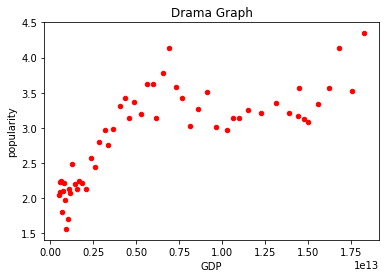

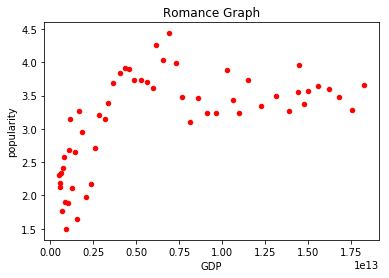

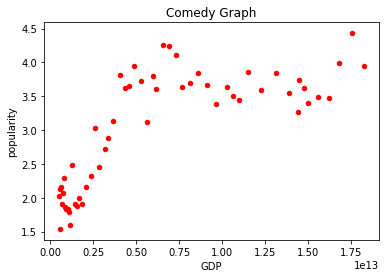

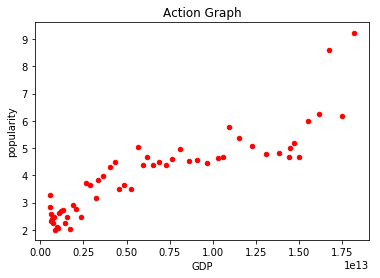

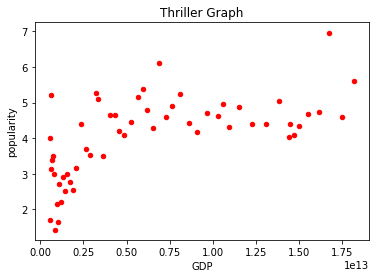

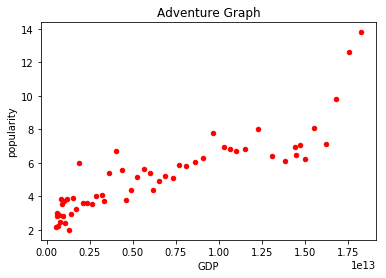

In [13]:
#Graphing each genre
drama_graph = drama.plot(kind='scatter', y='popularity', x='GDP',
                         color='red', title = '')
romance_graph = romance.plot(kind='scatter', y='popularity', x='GDP',
                             color='red')
comedy_graph = comedy.plot(kind='scatter', y='popularity', x='GDP',
                           color='red')
action_graph = action.plot(kind='scatter', y='popularity', x='GDP',
                           color='red')
thriller_graph = thriller.plot(kind='scatter', y='popularity', x='GDP',
                               color='red')
adventure_graph = adventure.plot(kind='scatter', y='popularity', x='GDP',
                                 color='red')
#Setting titles for graphs
drama_graph.set_title("Drama Graph")
romance_graph.set_title("Romance Graph")
comedy_graph.set_title("Comedy Graph")
action_graph.set_title("Action Graph")
thriller_graph.set_title("Thriller Graph")
adventure_graph.set_title("Adventure Graph")

Now that we have seen how each genre compares with gdp separately, we want to see how each genre compares against eachother side by side.

Text(0, 0.5, 'Popularity Score')

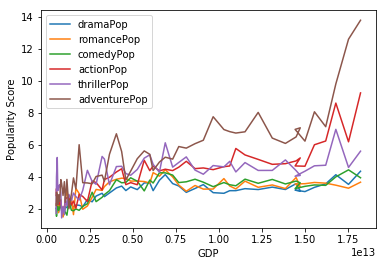

In [28]:
#Remove drama date
drama_df = drama
drama_df = drama_df.drop(columns='date',axis = 1)
drama_df.columns = ['dramaPop','GDP']

#Remove romance date
romance_df = romance
romance_df = romance_df.drop(columns='date',axis = 1)
romance_df.columns = ['romancePop','GDP']

#Remove comedy date
comedy_df = comedy
comedy_df = comedy_df.drop(columns='date',axis = 1)
comedy_df.columns = ['comedyPop','GDP']

#Remove action date
action_df = action
action_df = action_df.drop(columns='date',axis = 1)
action_df.columns = [ 'actionPop','GDP']

#Remove thriller date
thriller_df = thriller
thriller_df = thriller_df.drop(columns='date',axis = 1)
thriller_df.columns = ['thrillerPop','GDP']

#Remove adventure date
adventure_df = adventure
adventure_df = adventure_df.drop(columns='date',axis = 1)
adventure_df.columns = ['adventurePop','GDP']

#Merge all genres into one dataframe
df_merged_genres = pd.merge(drama_df,romance_df, how='inner')
df_merged_genres = pd.merge(df_merged_genres ,comedy_df, how='inner')
df_merged_genres = pd.merge(df_merged_genres ,action_df, how='inner')
df_merged_genres = pd.merge(df_merged_genres ,thriller_df, how='inner')
df_merged_genres = pd.merge(df_merged_genres ,adventure_df, how='inner')

df_merged_genres.plot(x='GDP', y=['dramaPop','romancePop',
                                  'comedyPop','actionPop','thrillerPop',
                        'adventurePop']).set_ylabel("Popularity Score")

Text(0, 0.5, 'Popularity Score')

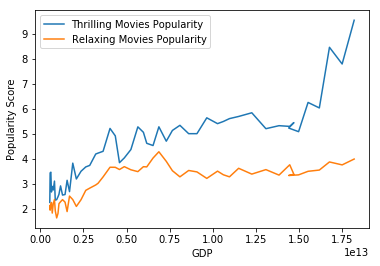

In [29]:
#merge relaxing genres and thrilling genres into their own dataframes
df_relaxing_merge = pd.concat([drama, comedy, romance])
df_thrilling_merge = pd.concat([action, adventure, thriller])

#Find average of popularity of thrilling movies and relaxing movies for each year
df_avg_thrill = df_thrilling_merge.groupby('date').mean()
df_avg_relax = df_relaxing_merge.groupby('date').mean()

df_avg_thrill.columns = ['Thrilling Movies Popularity', 'GDP']
df_avg_relax.columns = ['Relaxing Movies Popularity', 'GDP']

df_thrill_relax_merge = pd.merge(df_avg_thrill, df_avg_relax, how='inner')

df_thrill_relax_merge.plot(x='GDP', y=['Thrilling Movies Popularity',
                'Relaxing Movies Popularity']).set_ylabel('Popularity Score')


To see if there is a correlation between relaxing movies and gdp, we create an OLS using the relaxing movie dataframe, comparing popularity with GDP. We can see from the OLS that there is correlation, with a p-value of 0.00.

In [16]:
#OLS for relaxing movies
f0 = "popularity ~ GDP"
outcome_1, predictors_1 = patsy.dmatrices(f0, df_relaxing_merge,
                                          return_type = "matrix")
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     147.8
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           1.01e-24
Time:                        21:59:41   Log-Likelihood:                -137.18
No. Observations:                 168   AIC:                             278.4
Df Residuals:                     166   BIC:                             284.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4114      0.067     36.241      0.0

We then see if there is a correlation between thirlling movies and gdp, we create another OLS using the thrilling movie dataframe comparing popularity and GDP. We can see from the OLS that there is correlation, with a p-value of 0.00.

In [17]:
#OLS for thrilling movies
f0 = "popularity ~ GDP"
outcome_2, predictors_2 = patsy.dmatrices(f0, df_thrilling_merge,
                                          return_type = "matrix")
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     200.4
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           2.41e-30
Time:                        21:59:41   Log-Likelihood:                -272.38
No. Observations:                 168   AIC:                             548.8
Df Residuals:                     166   BIC:                             555.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8486      0.149     19.144      0.0

As we can see, it seems that thrilling moves are always more popular than relaxing movies. Since we know this, we should compare the relative popularity of thrilling movies and relaxing movies depending on GDP. By relative popularity we mean we should look at the popularity of the genre at the current GDP relative to the average popularity of the genre in general. We calculate this by taking the popularity of the genre at the year divided by the average of the popularity of the genre in general.

Text(0, 0.5, 'Popularity Score')

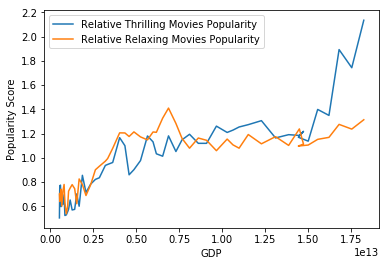

In [39]:
#Find avg of popularity of thrilling movies and relaxing movies for each year
df_avg_thrill = df_thrilling_merge.groupby('date').mean()
df_avg_relax = df_relaxing_merge.groupby('date').mean()

#Find how popular are the movie genres as a whole
df_total_thrill_pop = df_thrilling_merge['popularity'].mean()
df_total_relax_pop = df_relaxing_merge['popularity'].mean()

# Find the relative popularity of the genres
df_relative_thrill_pop = df_avg_thrill
df_relative_thrill_pop['popularity'] = (df_avg_thrill['popularity']/
                                        df_total_thrill_pop)
df_relative_thrill_pop.columns = ['Relative Thrilling Movies Popularity',
                                  'GDP']

df_relative_relax_pop = df_avg_relax
df_relative_relax_pop['popularity'] = (df_avg_relax['popularity']/
                                       df_total_relax_pop)
df_relative_relax_pop.columns = ['Relative Relaxing Movies Popularity',
                                 'GDP']

df_relative_thrill_relax = pd.merge(df_relative_thrill_pop, 
                                    df_relative_relax_pop,how='inner')
df_relative_thrill_relax.plot(x='GDP',
                              y=['Relative Thrilling Movies Popularity',
         'Relative Relaxing Movies Popularity']).set_ylabel('Popularity Score')

Now that we have compared the relative popularities, we can look at the difference between the realtive popularites. By graphing GDP vs The difference between Thrilling and Relative movie popularites, we can see when relaxing movies become relatively more popular than thrilling movies. Whenever the line is below 0.0 popularity, it means that the relaxing movies are relatively more popular than thrilling movies. As we can see in the graph, this is occurence happens more frequently at low GDPs than in high GDPs.

Text(0, 0.5, 'Popularity Score Difference')

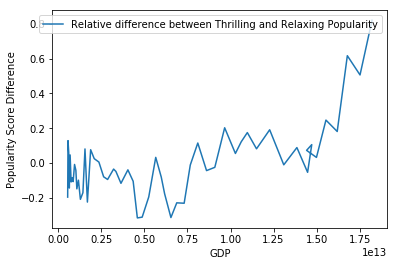

In [40]:
df_compare_relatives = df_relative_thrill_pop

df_compare_relatives['Relative Thrilling Movies Popularity'] = \
             (df_relative_thrill_pop['Relative Thrilling Movies Popularity'] - 
              df_relative_relax_pop['Relative Relaxing Movies Popularity'])

df_compare_relatives.columns = \
['Relative difference between Thrilling and Relaxing Popularity', 'GDP']

df_compare_relatives.plot(x='GDP', 
          y='Relative difference between Thrilling and Relaxing Popularity' \
                         ).set_ylabel('Popularity Score Difference')

Now use an OLS regression to test a linear relationship between the difference.

In [20]:
df_compare_relatives.columns = ['popularity_difference', 'GDP']

f0 = "popularity_difference ~ GDP"
outcome_3, predictors_3 = patsy.dmatrices(f0, df_compare_relatives,
                                          return_type = "matrix")
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                              OLS Regression Results                             
Dep. Variable:     popularity_difference   R-squared:                       0.400
Model:                               OLS   Adj. R-squared:                  0.389
Method:                    Least Squares   F-statistic:                     36.06
Date:                   Wed, 12 Jun 2019   Prob (F-statistic):           1.67e-07
Time:                           21:59:42   Log-Likelihood:                 23.180
No. Observations:                     56   AIC:                            -42.36
Df Residuals:                         54   BIC:                            -38.31
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1575 

# Data Analysis & Results

We found that there are trends between GDP per capita and popularity of movies. In general, when there is low GDP, the popularity of each genre is low. We noticed that for comedy, drama, and romance, the popularity would increase with GDP until a certain point where they stopped increasing. On average, these “relaxing” genres would grow rapidly until a popularity score of about 4 where they would stay. On the other hand, action and adventure would have a linear relationship with GDP and would keep growing past a popularity score of 4. Thriller, which we thought would act similar to action and adventure movies, turned out to be more similar to the relaxing genres and would cap out at a popularity score of 4.

When we compared each genre together on the same graph, we can see that most of the genres have some sort of increase in popularity as gdp goes up. The thrilling movies, adventure, action, and thriller, have a more rapid growth as GDP increases. Adventure movies are an outlier with a sharp increase as gdp increases, but in general the thrilling movies have a higher growth than relaxing movies. The relaxing movies, drama, romance, and comedy, all have a small growth as GDP increases, and they are all relatively the same popularity as GDP increases. 
	
After grouping the genres into two dataframes, relaxing and thrilling, we were able to see a more direct relationship between relaxing movies and thrilling movies. We see that thrilling movies in general despite gdp, are more popular than relaxing movies. Thrilling movies however, have an increase in popularity as gdp increases, in a linear way. Relaxing movies have a very small increase in popularity as gdp increases, with the graph plateauing as gdp becomes 0.5 * 1e13. After running the test of significance, we found out that both relaxing movies and thrilling movies have a linear correlation with GDP. For both relaxing and thrilling movies, we saw a p-value of 0.00.

However since we have seen that thrilling movies will be, in general, more popular than  relaxing movies, we decided to analyze the relative popularity of thrilling and relaxing movies at certain GDPs. We found this by looking at the average popularity of thrilling movies at a certain GDP and dividing this by the average of the popularity of thrilling movies at all GDPs. We did this for relaxing movies as well. This gave us a dataframe of the relative popularity of thrilling and relaxing movies.

To further investigate the relative popularities, we graphed the difference between the popularity of thrilling and relaxing movies vs GDP. Whenever this value is below 0, it means that relaxing movies were relatively more popular than thrilling movies at that certain GDP. As we can see in the graph, the line is below 0 more often during low GDPs while the line is above 0 more often in high GDPs. This information is relevant to our hypothesis. While our hypothesis was not completely correct since thrilling movies are more popular in general, this information shows that at low GDPs comedies are relatively more popular than thrilling movies and at high GDPs thrilling movies are relatively more popular than relaxing movies.

The OLS regression results showed that there was a linear relationship between the difference in popularity and GDP. The p value was 0.00 meaning it passes the test of significance. Furthermore the intercept was a negative number, meaning at low GDP values, relaxing movies are relatively more popular, but at higher GDP values, thrilling movies are relatively more popular.


# Ethics & Privacy

Our data relies on the GDP per capita and movies throughout the years. To get this data, we found datasets on the web with this information but we must also consider the ethics of these sources. For our movie data, there is not much ethical considerations to consider. The main ethical consideration is if there are any certain types of movies that were purposely left out of the dataset. However, this is most likely not the case as there were many movies that were included in our dataset and the website stated that the dataset was from GroupLens, which is a group that is fairly unbiased and has no reason to purposely exclude movies. This group is also where the popularity comes from, but since this group is fairly unbiased, there is no reason to doubt their popularity choices too much. 

The GDP per capita data has a lot of ethical considerations to think about. The GDP per capita contains information about the income of American citizens. It is important that the GDP is found without leaking any personal information. However, GDP is just a number that has no links back to personal information, so GDP will not have any personal information associated to it. Furthermore, it is important to make sure that no races are excluded from GDP, but since the government knows that they must be ethical, the GDP that they calculate must also be fair and unbiased. 

Our study is combining both of these ethical sources and finding the correlation between them so our study will also be ethical. Since our sources have no personally identifiable data, it is impossible for our study to have personally identifiable data. Our analysis is also unbiased since the sources we used were fair and unbiased. Finding a correlation between these two may cause movie producers to wait to release their movie when there is an increase or decrease in GDP per capita. This is not too big of an issue since releasing a movie slightly later will not adversely affect anyone.


# Conclusion & Discussion

In this project, we begin with asking “what is the relationship between genre preference and economy performance”. We defined economy performance using  GDP, and we split the possible movie preferences into six different genres. However, we further grouped the movies into thrilling movies and relaxing movies. Thrilling movies included action, adventure, and thrillers, while relaxing movies included romance, dramas, and comedies. After data wrangling, cleaning, and visualization, we found out that thrilling movies are generally more popular than relaxing movies at all GDPs, so we had to analyze the relative popularity of each movie instead. We found the relative popularity by looking at the popularity of the movies at that GDP divided by the popularity of it at all GDPs. By looking at the relative popularities, we found that at lower GDPs relaxing movies are relatively more popular than thrilling movies while at higher GDPs thrilling movies are relatively more popular than relaxing movies.

Although we did a lot in this project, there are still some limits. First, a major issue of this project is that correlation does not imply causation, so correlational study like this may not be useful to accurately predict the future. Furthermore, the correlation we found in our analysis is not very strong, and may be due to randomness or third variables: we think this project can be improved through utilizing better indicators for the economy and its effect on individual lives, since GDP per capita is too general and may be affected by other factors besides economy. By doing so, we believe the relation we found will be more robust. There are also confounding variables. A major confounding variable we saw was the fact that GDP always is increasing. This means that instead of only looking at GDP we are actually looking at how movie preferences change over the years. Another confounding variable is the fact that people could just prefer certain genres based on their culture instead of their economical status.

Even if this may not be a very influential or mature project, it can still have a positive influence on society. Because our topic of research is relatively new, it may point a direction for future analysis and research. Also, this project may serve as a guidance for movie production, as we know movie preference is correlated with the economy, so movie companies can know what movie they should produce more. Also, since we found correlation even when it seemed like there shouldn't have been, this can inspire other data scientists to investigate anything that interests them, despite whether they believe there will be correlation.
